In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [2]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X_raw = pd.read_csv("../Datasets/covariates.csv")

In [3]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
Model_metrics = pd.DataFrame(columns=['WAIC', 'LOO', 'MSE', 'MAE', 'MAD', 'inside CI', 'over max'])

# Base Model

In [6]:
model_base = FetchModel('base').compile()

16:15:03 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\base.exe
16:15:28 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\base.exe


In [7]:
data_base = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "y": Y_obs['Count_120'],
    "X": X_obs
}

fit_base = model_base.sample(data=data_base, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_base = az.from_cmdstanpy(fit_base)

16:15:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:15:55 - cmdstanpy - INFO - CmdStan done processing.


In [8]:
post_pred = PostPred(posterior_120_base, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

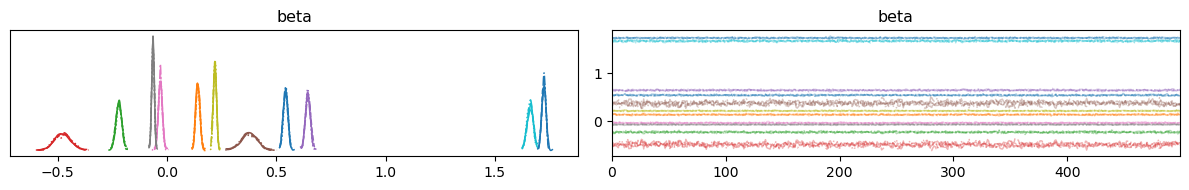

In [9]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta'])
plt.tight_layout()
plt.show()

In [10]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13592.87   235.55
p_waic       40.90        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13592.93   235.55
p_loo       40.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [11]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [12]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   8   12   13   21   34   48   54   56   57   69   80   98  132  141
  145  154  157  165  166  169  173  211  212  213  227  234  238  271
  272  309  310  316  343  346  363  371  378  380  383  384  385  391
  394  403  404  407  410  413  414  420  422  429  430  433  472  478
  479  481  482  486  488  493  512  513  519  525  558  581  595  598
  599  600  605  608  613  634  643  647  648  650  657  658  662  665
  669  685  688  689  690  695  705  708  709  739  747  752  753  757
  758  760  767  768  769  770  771  774  775  776  781  782  787  788
  789  790  833  837  842  846  863  864  874  876  877  878  901  908
  911  917  924  925  926  927  930  931  932  933  936  937  938  941
  942  943  944  945  946  949  956  957  958  959  960  963  964  968
  969  971  972  976  977  978  979  981  982  983  984  985  986  989
  990  991  992  993  997  998  999 1000 1006 1011 1012 1016 1021 1029
 1039 1053 1059 1065 1066 1070 1072 1073 1078 1079 1080 1081 1091 1

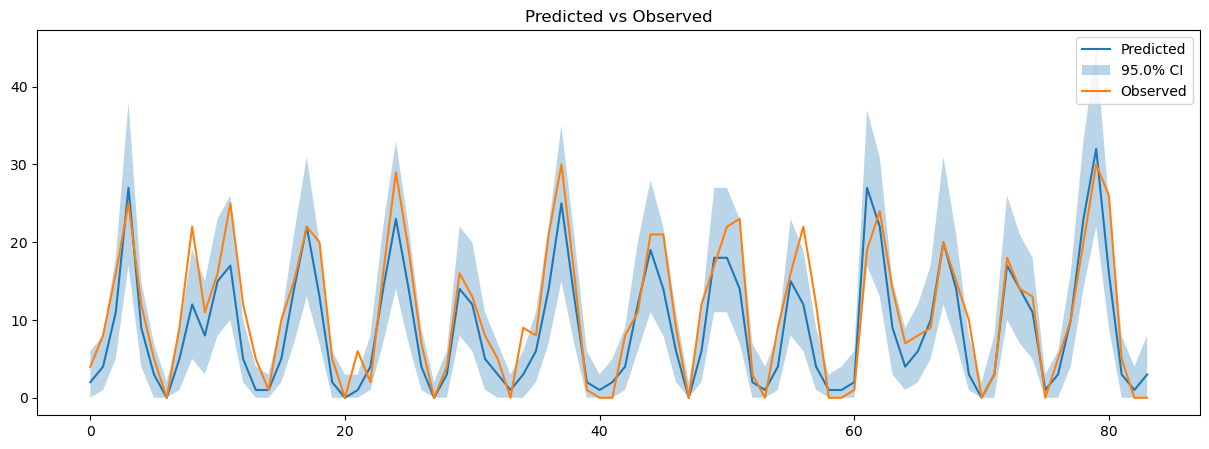

In [13]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [14]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

56


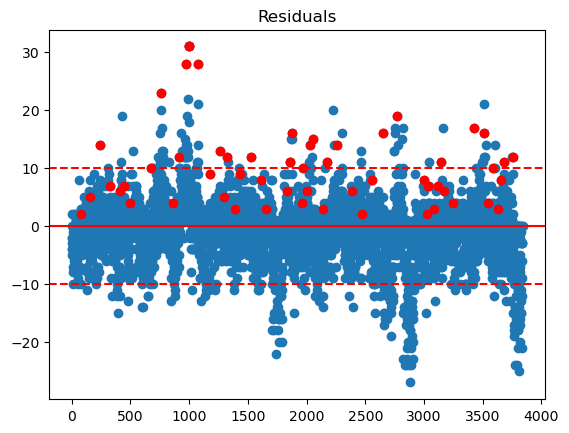

In [15]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

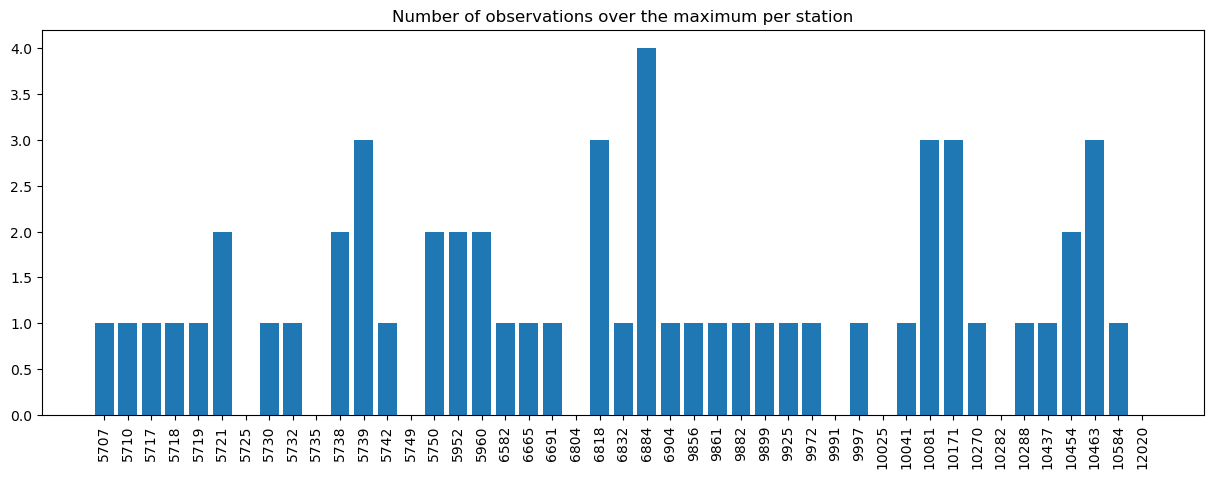

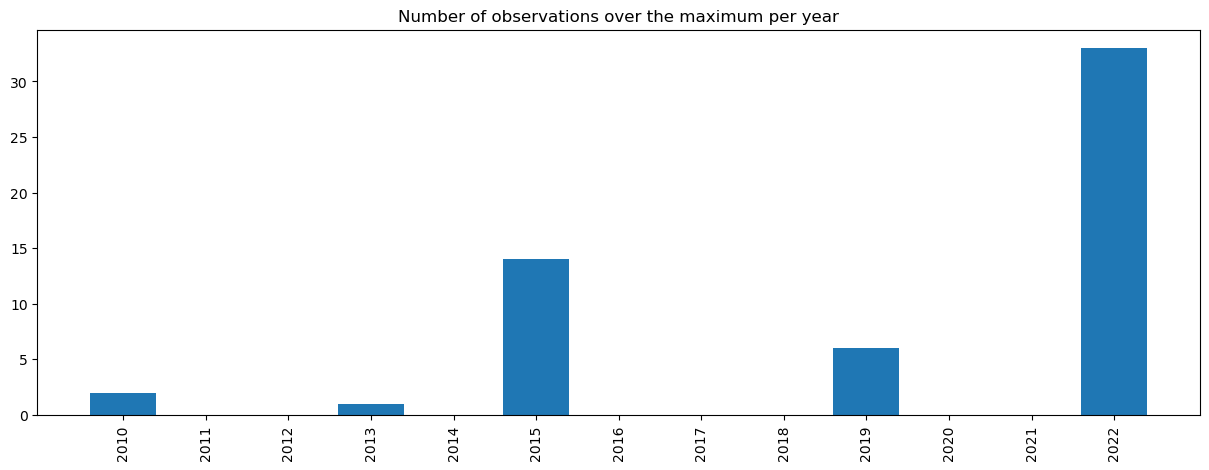

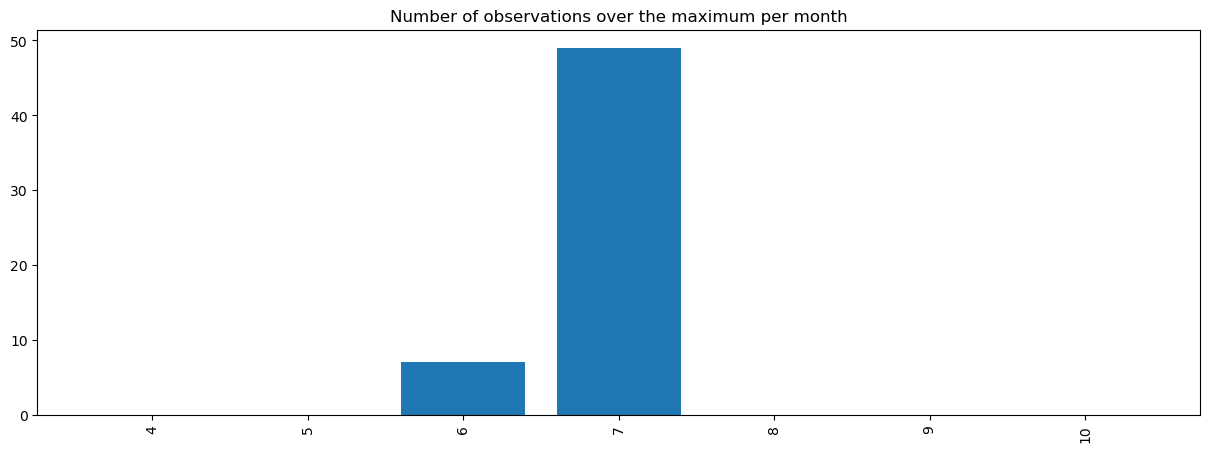

In [16]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [17]:
Model_metrics.loc['Base',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

              WAIC           LOO        MSE       MAE  MAD inside CI over max
Base -13592.873226 -13592.929901  29.751562  3.770313  3.0  0.805469       56


# Year model
We add the factor accounting for different years.

In [18]:
model_years = FetchModel('years').compile()

16:16:13 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\years.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\years.exe
16:16:54 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\years.exe


In [19]:
data_years = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs
}

fit_years = model_years.sample(data=data_years, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_years = az.from_cmdstanpy(fit_years)

16:17:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:18:10 - cmdstanpy - INFO - CmdStan done processing.


In [20]:
post_pred = PostPred(posterior_120_years, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

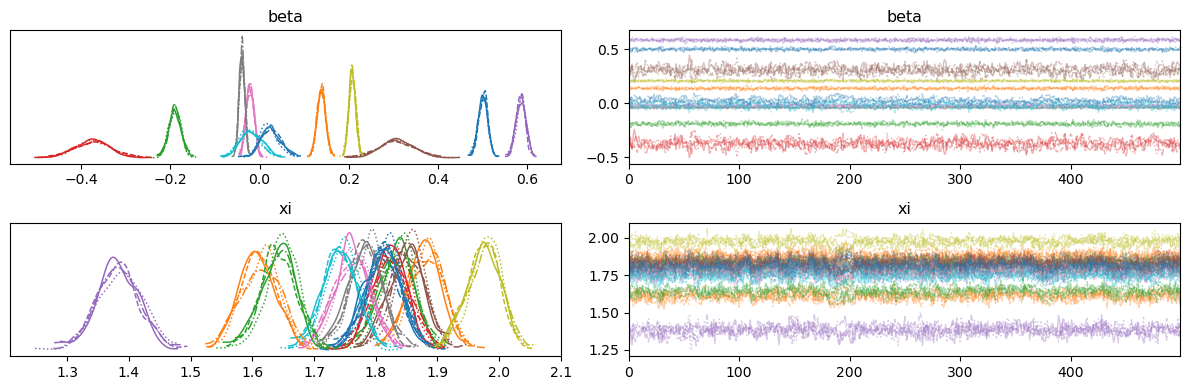

In [21]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi'])
plt.tight_layout()
plt.show()

In [22]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11141.54   115.14
p_waic       57.50        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11141.71   115.15
p_loo       57.67        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [23]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [24]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   8   21   34   51   57   69   80   83   99  145  154  165  179  227
  234  264  308  309  310  346  350  363  371  384  385  391  394  403
  404  407  410  414  420  422  428  429  430  433  452  472  478  479
  481  482  486  488  493  505  512  514  519  525  544  545  550  581
  585  595  599  600  605  608  609  613  618  634  640  643  647  648
  650  658  662  665  669  675  688  689  690  695  699  705  708  739
  747  753  757  760  765  767  768  769  770  771  774  775  776  781
  782  787  789  797  808  842  846  861  863  864  874  876  877  901
  908  911  924  925  926  927  930  931  932  933  936  937  938  942
  943  945  949  956  957  958  959  960  963  964  968  969  970  971
  972  976  977  978  979  981  982  983  984  985  986  989  990  991
  992  993  997  998  999 1000 1006 1007 1011 1012 1017 1020 1021 1039
 1049 1053 1059 1065 1066 1070 1073 1078 1079 1081 1101 1105 1129 1130
 1133 1136 1144 1146 1153 1158 1165 1167 1168 1171 1179 1185 1191 1

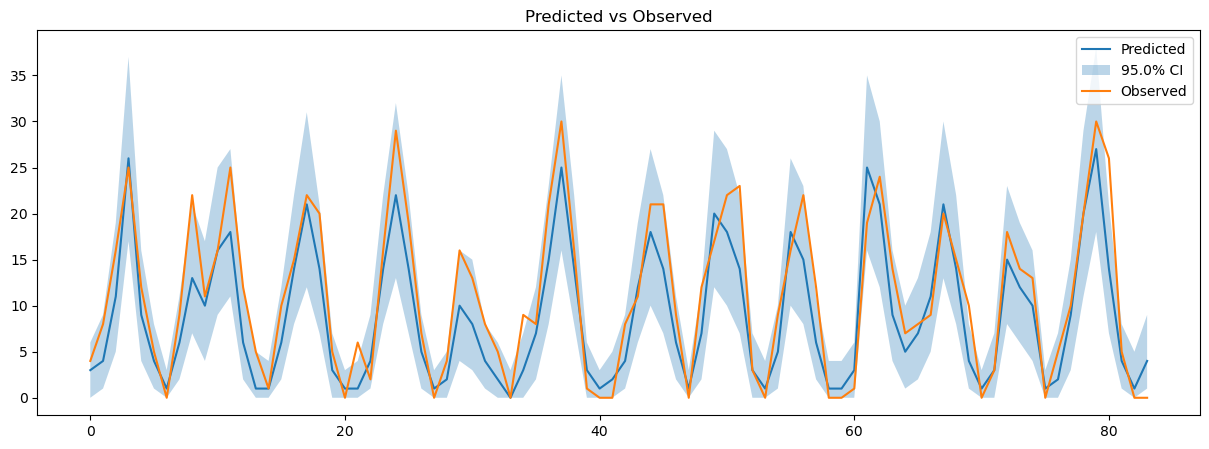

In [25]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [26]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

23


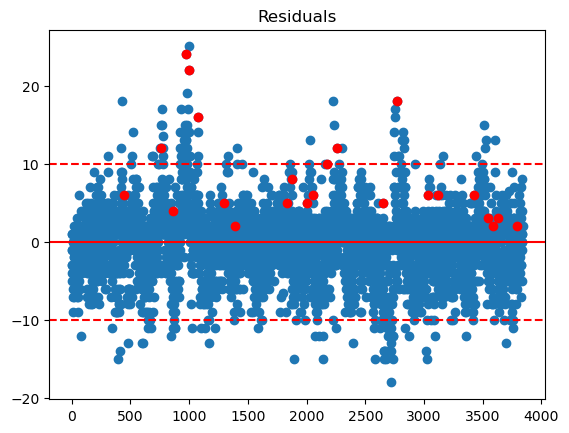

In [27]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

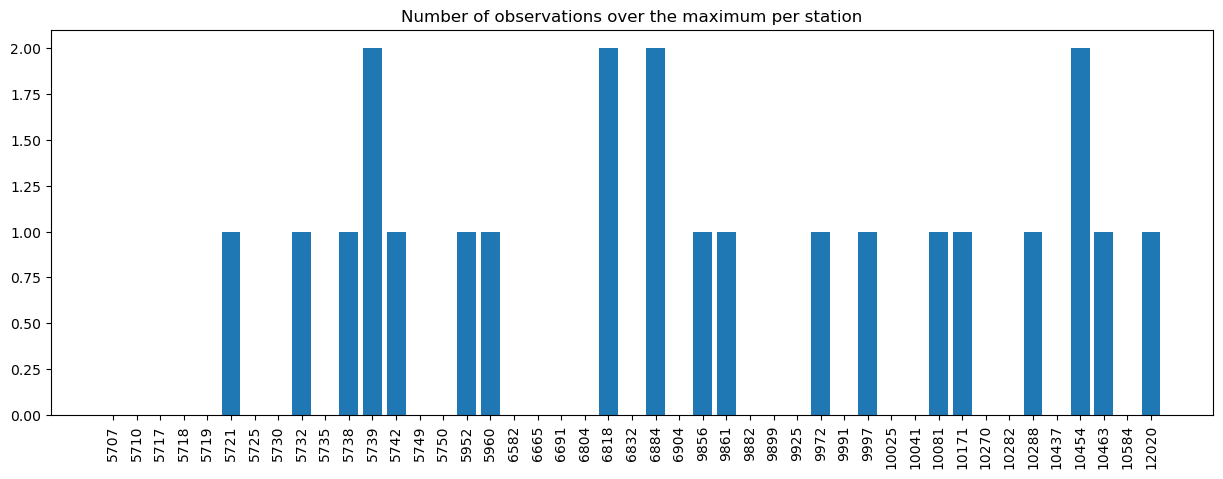

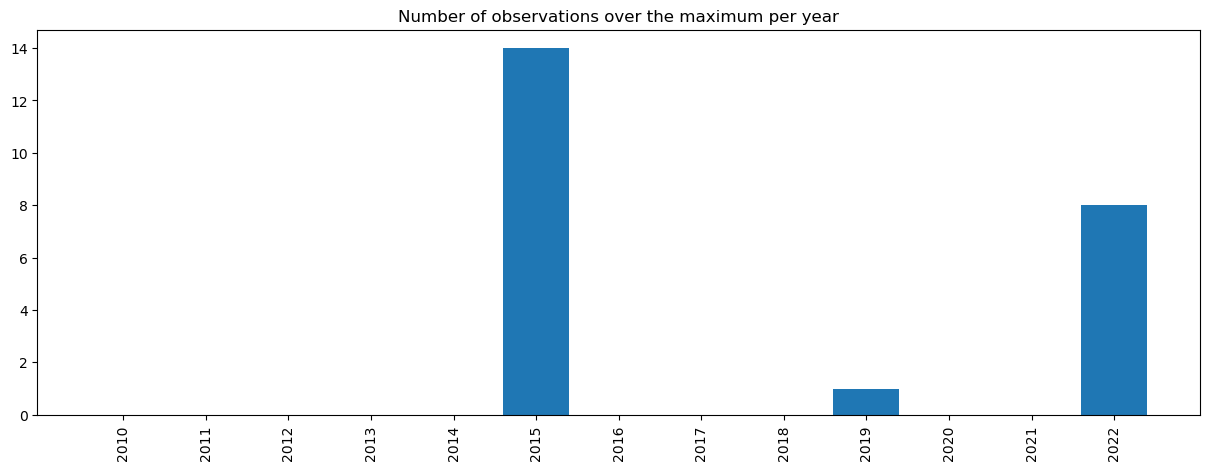

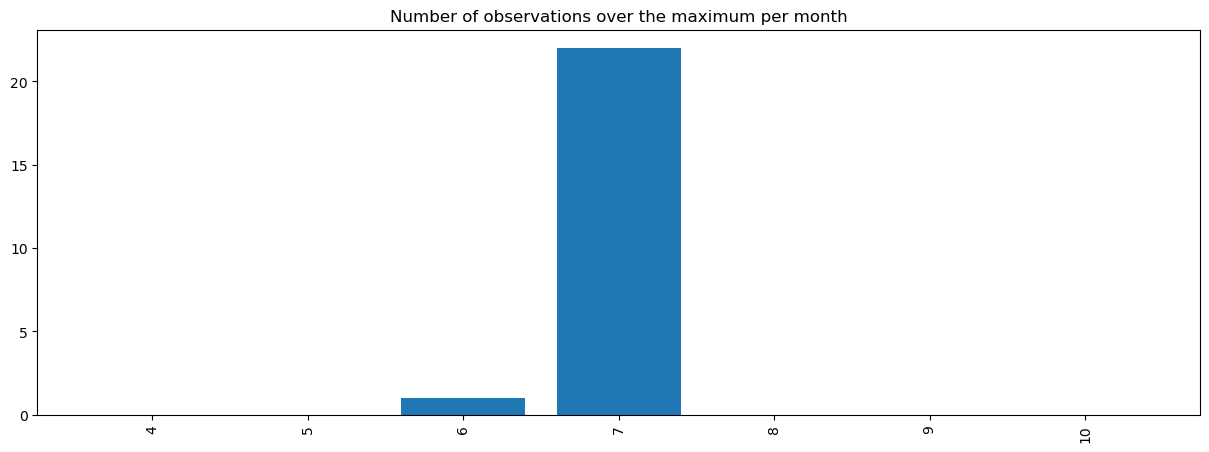

In [28]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [29]:
Model_metrics.loc['Years',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

               WAIC           LOO        MSE       MAE  MAD inside CI over max
Base  -13592.873226 -13592.929901  29.751562  3.770313  3.0  0.805469       56
Years -11141.536342 -11141.712072  19.525391      3.25  2.0  0.861979       23


# Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [30]:
model_stations = FetchModel('stations').compile()

16:19:22 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\stations.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\stations.exe
16:20:42 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\stations.exe


In [31]:
data_stations = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs
}


fit_stations = model_stations.sample(data=data_stations, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_stations = az.from_cmdstanpy(fit_stations)

16:20:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:33:19 - cmdstanpy - INFO - CmdStan done processing.


16:33:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 182 iterations at max treedepth (36.4%)
	Chain 2 had 108 iterations at max treedepth (21.6%)
	Chain 3 had 118 iterations at max treedepth (23.6%)
	Chain 4 had 98 iterations at max treedepth (19.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [32]:
post_pred = PostPred(posterior_120_stations, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

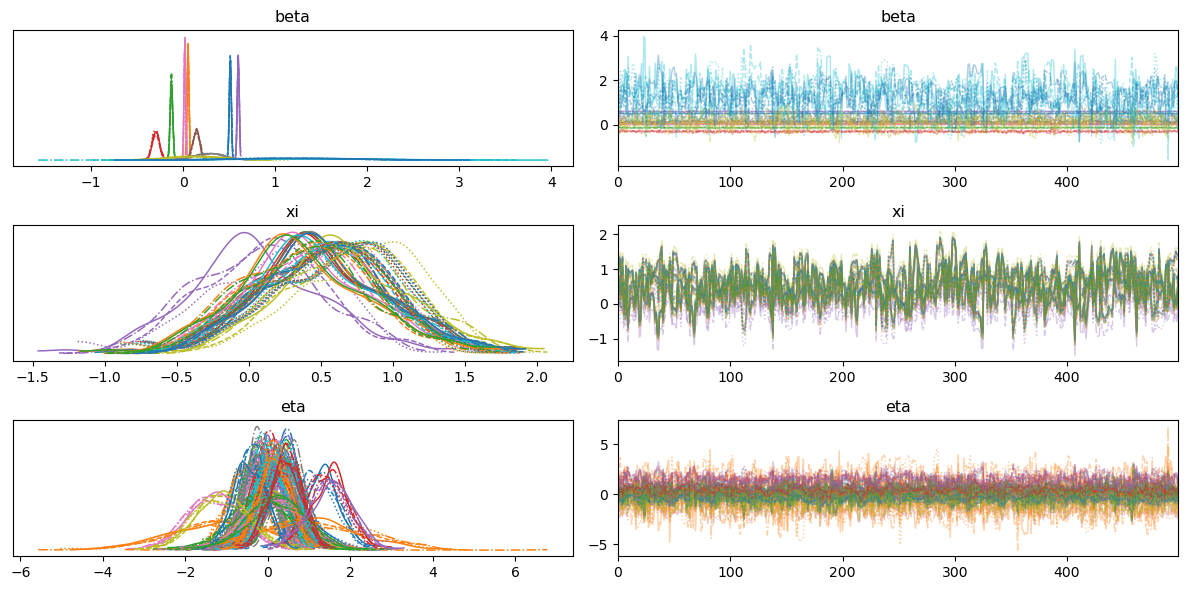

In [33]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta'])
plt.tight_layout()
plt.show()

In [34]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10099.19    86.21
p_waic      103.70        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10099.55    86.22
p_loo      104.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [35]:
eta = post_pred.posterior.eta
eta
len(np.unique(stations))

45

In [36]:
lam = post_pred.posterior['lambda']

In [37]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [38]:
inference_lam = []
for i in range(len(Y_obs['Count_120'])):
    ar1 = lam[0, :, i]-Y_obs['Count_120'][i]
    ar2 = lam[1, :, i]-Y_obs['Count_120'][i]
    ar3 = lam[2, :, i]-Y_obs['Count_120'][i]
    ar4 = lam[3, :, i]-Y_obs['Count_120'][i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference_lam.append(current_iteration_df)

In [39]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original[idx_obs])
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [40]:
df = pd.DataFrame(inference_lam).transpose()
df.shape
df.columns.values

array([   0,    1,    2, ..., 3837, 3838, 3839], dtype=int64)

In [41]:
import os
if not os.path.exists('../Datasets/Space_estimate'):
    os.makedirs('../Datasets/Space_estimate')

csv_path = '../Datasets/Space_estimate/eta_120.csv'
data = pd.DataFrame(df)
data.to_csv(csv_path, index=False)

csv_path = '../Datasets/Space_estimate/res_120.csv'
data = pd.DataFrame(df)
data.to_csv(csv_path, index=False)

In [42]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [43]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   34   83   99  145  154  165  227  234  286  308  309  350  351
  362  363  385  391  394  396  404  410  413  414  420  422  429  433
  472  478  479  481  482  486  488  493  512  513  519  551  581  582
  585  588  599  609  618  634  643  648  650  662  665  669  680  682
  685  690  695  701  718  749  753  757  769  770  771  774  775  777
  781  787  799  802  807  824  835  842  846  863  864  869  874  876
  877  884  917  919  920  921  931  950  955  962  970  984 1012 1016
 1019 1021 1022 1026 1032 1042 1049 1053 1073 1105 1118 1146 1158 1165
 1168 1179 1185 1195 1222 1248 1255 1283 1329 1331 1341 1371 1384 1385
 1407 1408 1449 1468 1527 1535 1540 1552 1563 1591 1611 1623 1631 1639
 1765 1774 1786 1824 1859 1867 1869 1874 1880 1889 1897 1903 1911 1912
 1923 1953 1955 1960 1978 1983 1989 2026 2029 2050 2075 2076 2089 2115
 2119 2127 2134 2137 2140 2144 2160 2180 2198 2214 2221 2227 2228 2234
 2238 2241 2250 2251 2274 2291 2301 2315 2327 2332 2363 2367 2375 2

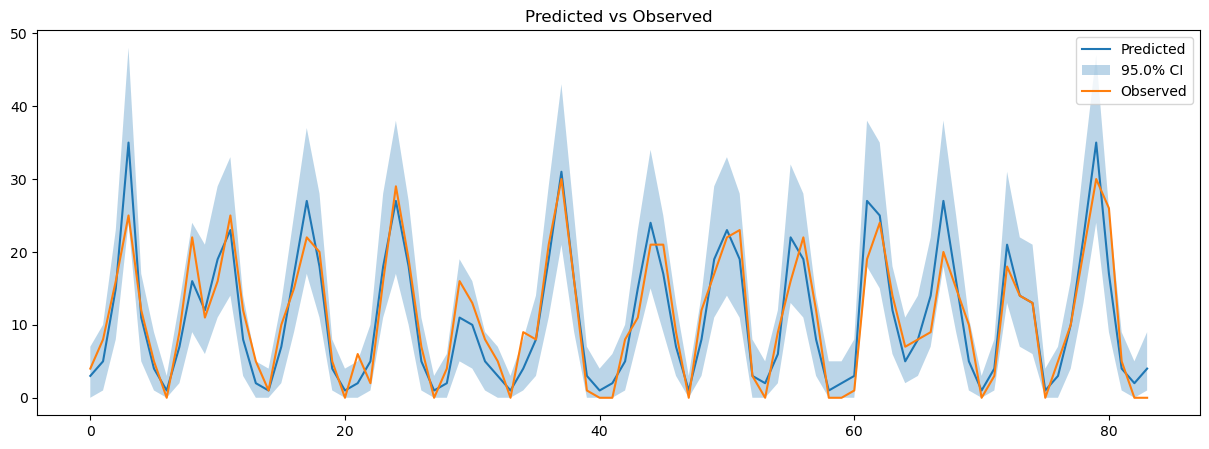

In [44]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [45]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

48


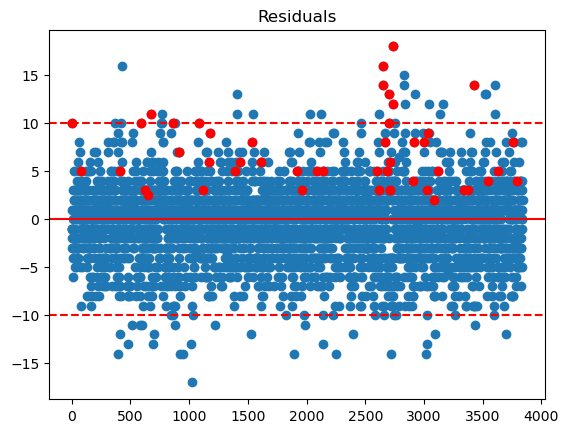

In [46]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

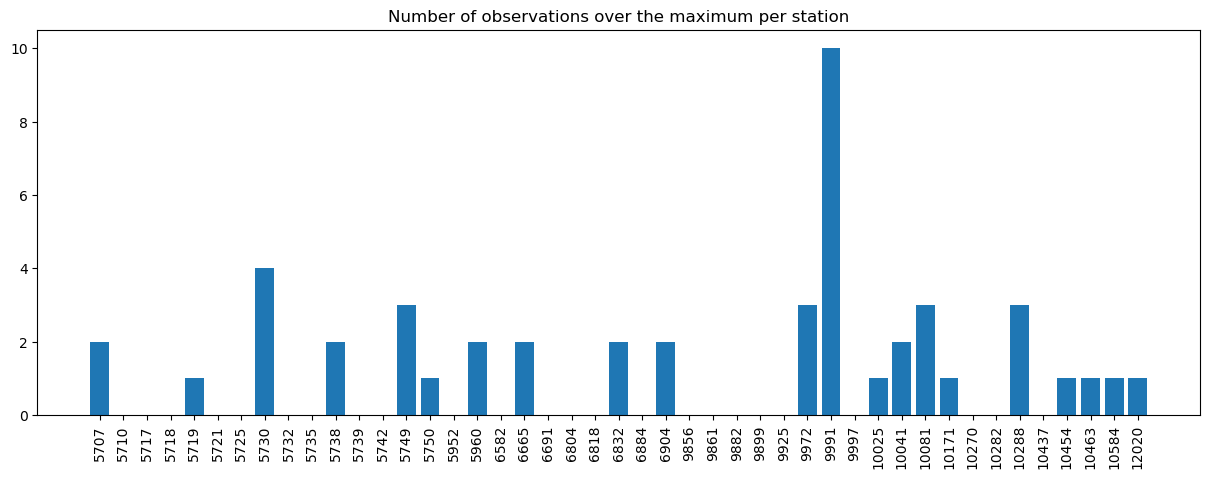

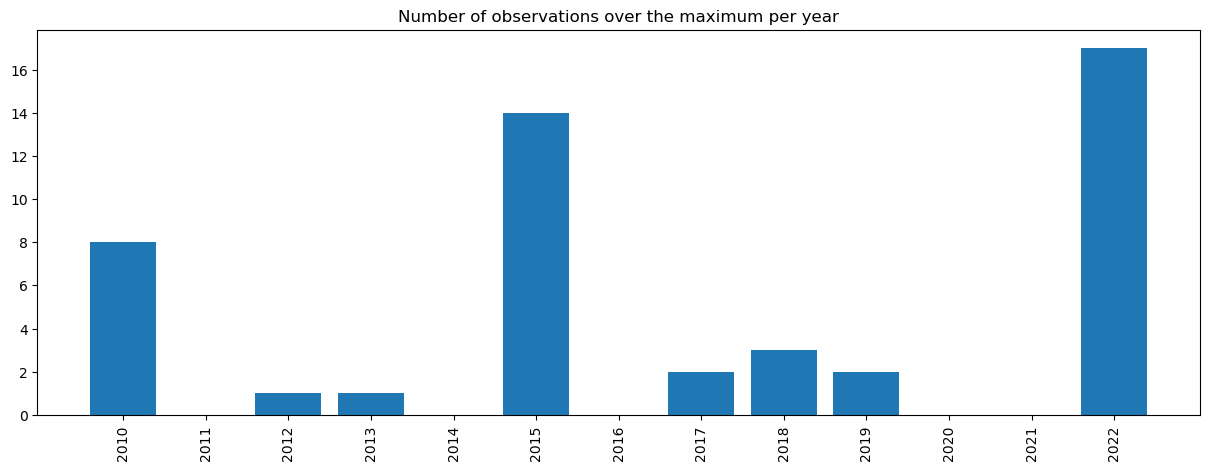

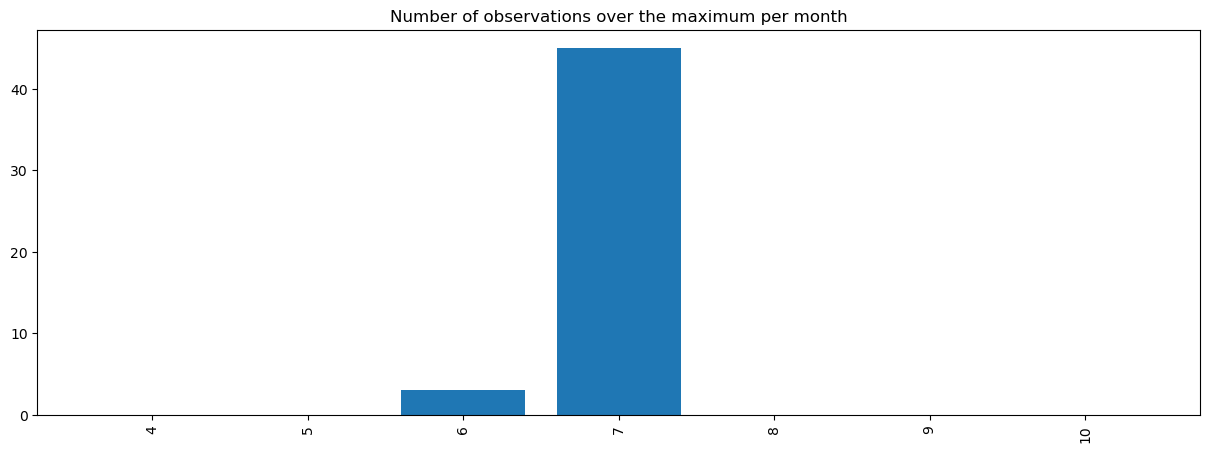

In [47]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [48]:
Model_metrics.loc['Stations',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                  WAIC           LOO        MSE       MAE  MAD inside CI  \
Base     -13592.873226 -13592.929901  29.751562  3.770313  3.0  0.805469   
Years    -11141.536342 -11141.712072  19.525391      3.25  2.0  0.861979   
Stations -10099.189027 -10099.548656  13.998958  2.791406  2.0  0.910677   

         over max  
Base           56  
Years          23  
Stations       48  


# Space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [49]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [50]:
model_space = FetchModel('space').compile()

In [51]:
data_space = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}


fit_space = model_space.sample(data=data_space, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_space = az.from_cmdstanpy(fit_space)

16:34:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:38:13 - cmdstanpy - INFO - CmdStan done processing.
16:38:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'space.stan', line 34, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', 

In [52]:
post_pred = PostPred(posterior_120_space, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

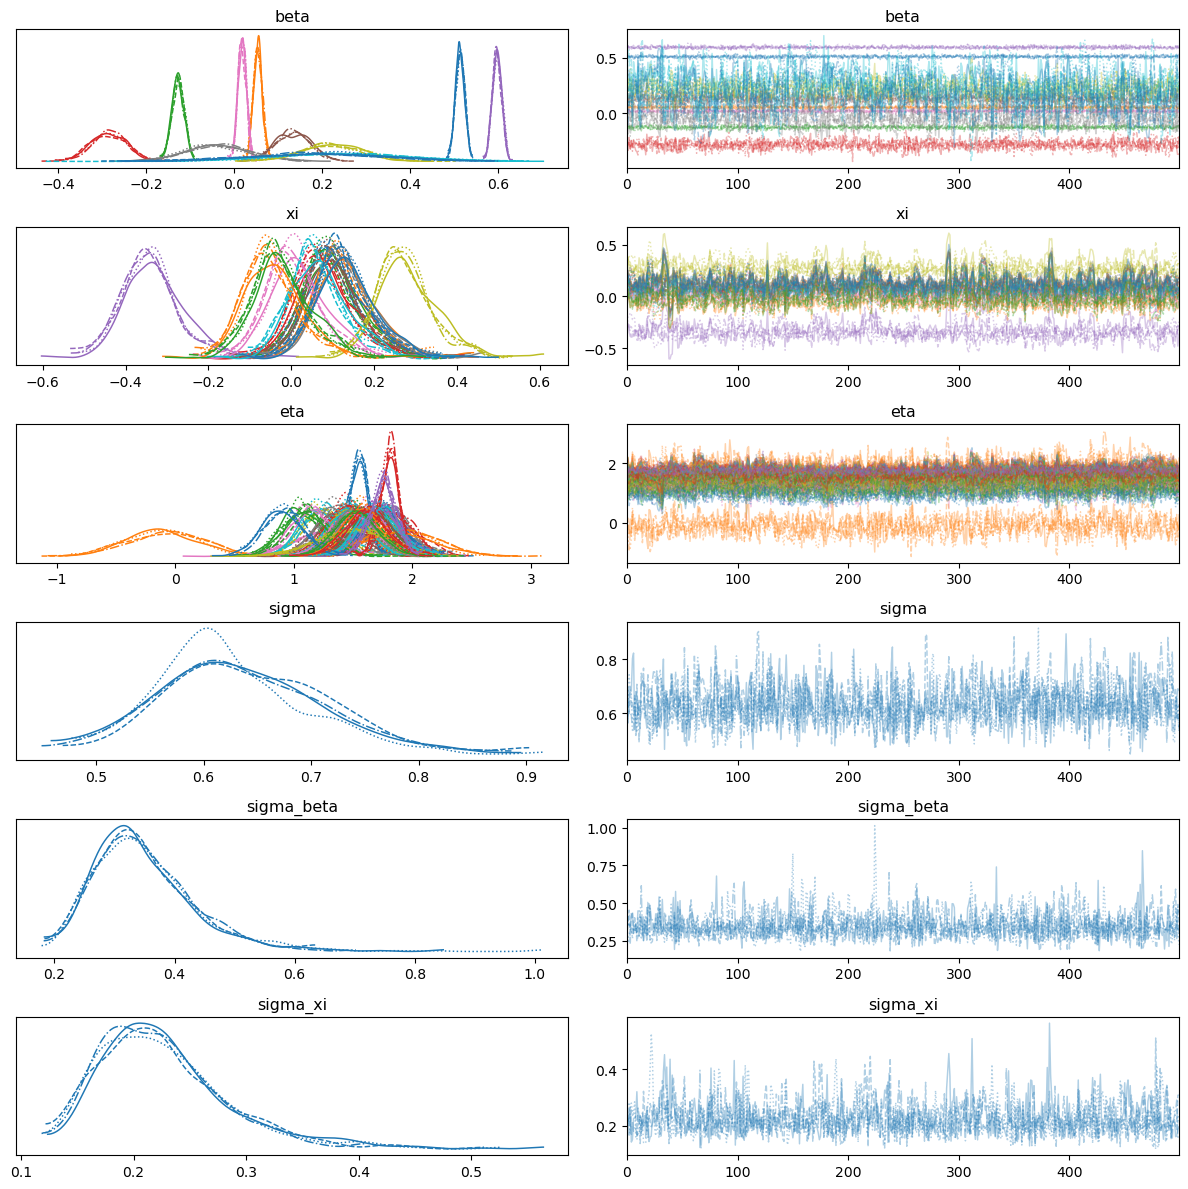

In [53]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [54]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10100.79    86.10
p_waic      101.89        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10101.13    86.11
p_loo      102.24        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3839  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [55]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [56]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   83  145  154  165  173  227  234  309  350  351  362  363  385
  391  394  396  404  410  413  414  420  422  429  433  472  478  479
  481  482  486  488  493  512  513  519  551  581  582  585  599  609
  618  643  648  650  662  665  669  680  682  685  690  695  701  718
  753  757  769  770  771  774  775  781  799  802  807  824  835  842
  863  864  869  874  876  877  884  917  919  920  921  931  950  955
  962  970  984  985 1012 1016 1019 1021 1022 1026 1032 1042 1053 1073
 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1248 1283 1329 1331
 1341 1371 1384 1385 1407 1408 1449 1457 1527 1535 1540 1552 1563 1591
 1611 1631 1639 1765 1774 1786 1824 1848 1859 1867 1869 1874 1880 1889
 1897 1903 1911 1912 1923 1953 1955 1960 1978 1983 1989 2026 2029 2050
 2070 2075 2076 2089 2115 2119 2127 2134 2137 2140 2144 2160 2180 2198
 2221 2227 2228 2233 2234 2238 2241 2250 2251 2274 2291 2301 2315 2327
 2332 2363 2367 2375 2382 2398 2399 2406 2412 2430 2458 2460 2462 2

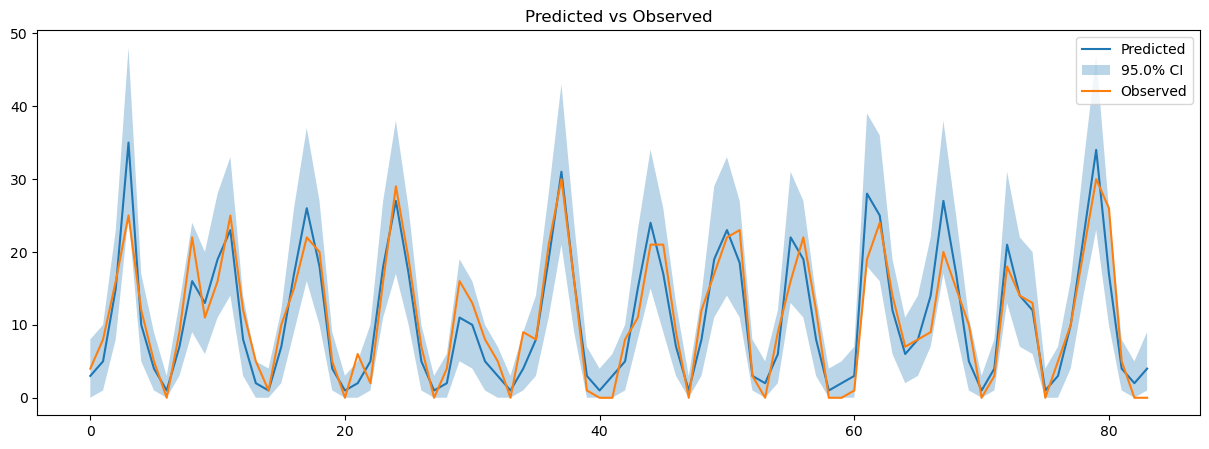

In [57]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [58]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

50


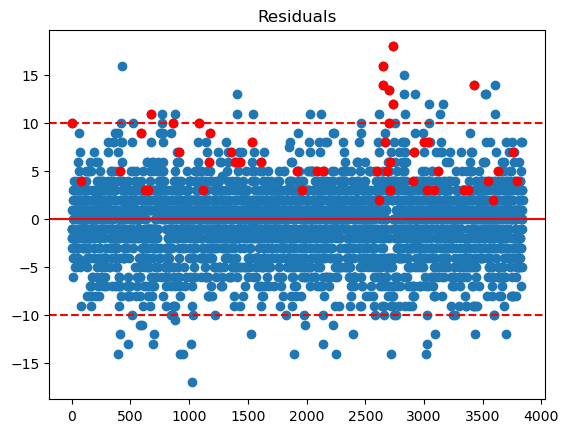

In [59]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

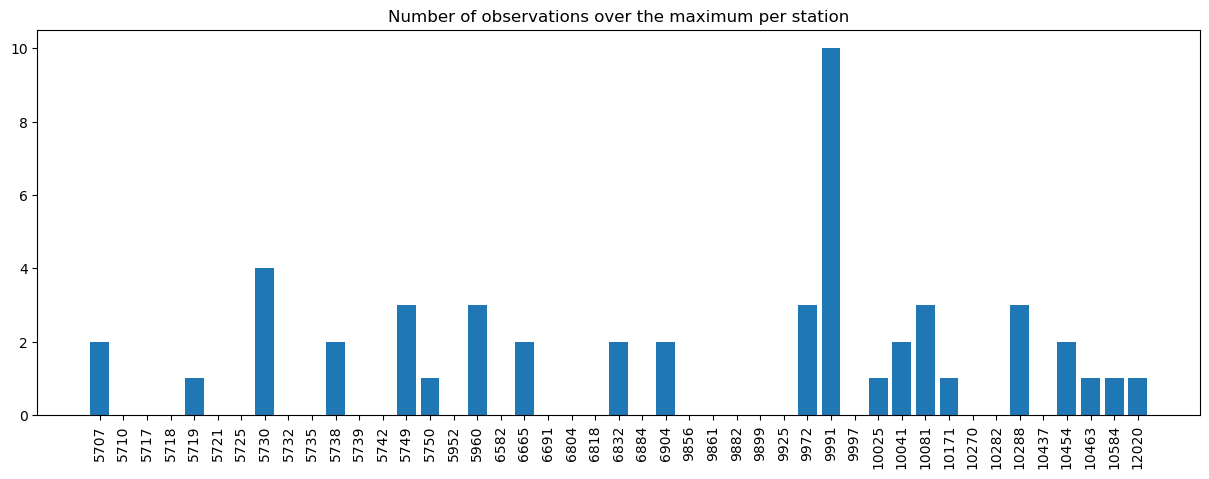

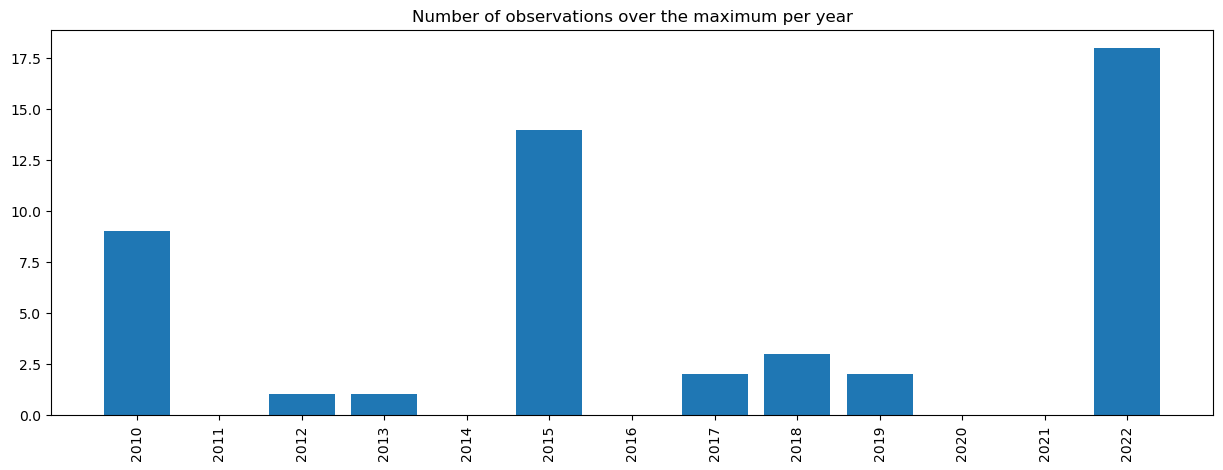

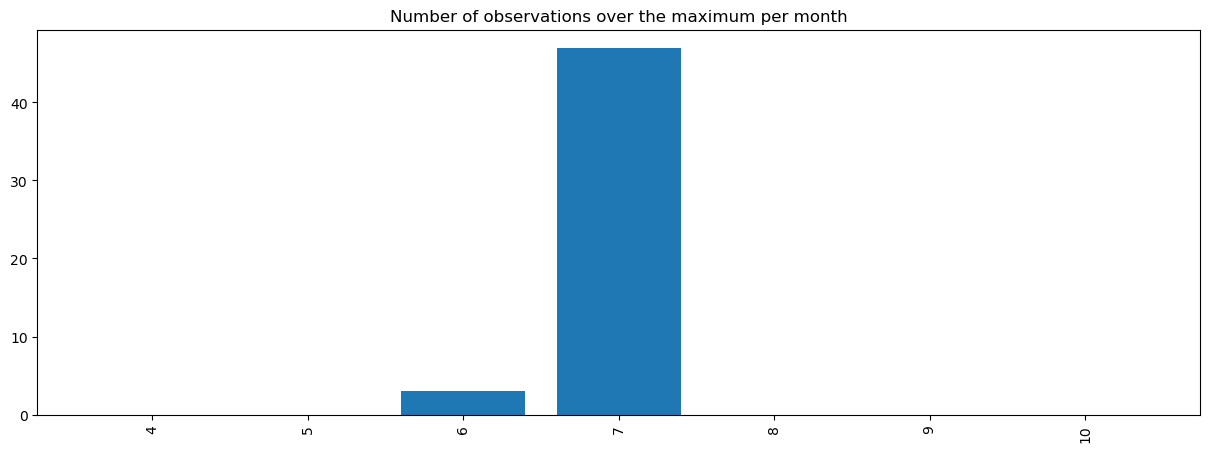

In [60]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [61]:
Model_metrics.loc['Spatial',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                  WAIC           LOO        MSE       MAE  MAD inside CI  \
Base     -13592.873226 -13592.929901  29.751562  3.770313  3.0  0.805469   
Years    -11141.536342 -11141.712072  19.525391      3.25  2.0  0.861979   
Stations -10099.189027 -10099.548656  13.998958  2.791406  2.0  0.910677   
Spatial  -10100.786528 -10101.132555  13.977995  2.791146  2.0  0.911458   

         over max  
Base           56  
Years          23  
Stations       48  
Spatial        50  


In [63]:
model_space_bis = FetchModel('space_bis').compile()

In [74]:
data_space_bis = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}


fit_space_bis = model_space_bis.sample(data=data_space_bis, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_space_bis = az.from_cmdstanpy(fit_space_bis)

16:50:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:55:32 - cmdstanpy - INFO - CmdStan done processing.
16:55:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_b

In [75]:
post_pred = PostPred(posterior_120_space_bis, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

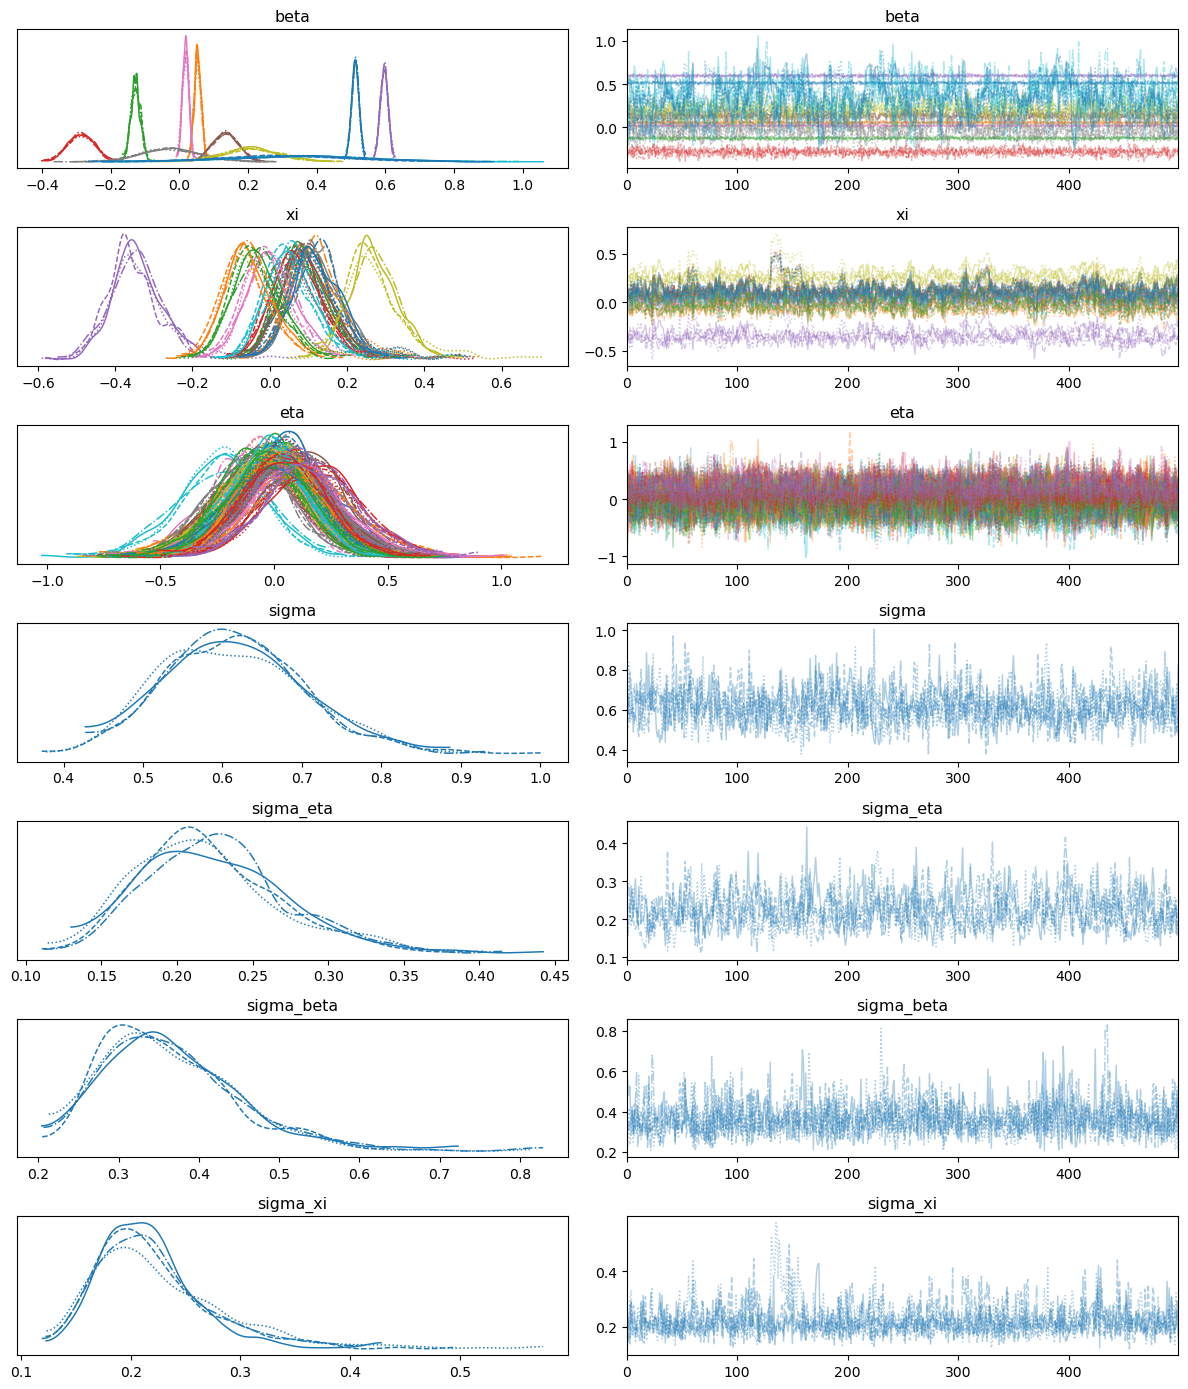

In [76]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [77]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10100.16    86.11
p_waic      101.61        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10100.42    86.12
p_loo      101.87        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [78]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [79]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   83   99  145  154  165  173  227  234  308  309  350  362  363
  391  394  396  404  410  413  414  420  422  429  430  433  472  478
  479  481  482  486  488  493  512  513  519  551  581  582  585  588
  599  609  618  634  643  648  650  662  665  669  680  682  685  690
  695  701  718  753  757  769  770  771  774  775  777  781  787  799
  802  807  824  835  842  846  863  864  869  874  876  877  884  901
  917  919  920  921  931  950  955  962  970  984 1012 1016 1019 1021
 1022 1026 1032 1042 1049 1053 1073 1105 1118 1146 1158 1165 1168 1179
 1185 1195 1222 1248 1255 1283 1329 1331 1341 1371 1384 1385 1407 1408
 1449 1457 1527 1535 1540 1552 1591 1611 1631 1639 1765 1774 1786 1824
 1848 1859 1867 1869 1874 1880 1889 1897 1903 1911 1912 1923 1953 1955
 1960 1978 1983 1989 2008 2026 2029 2050 2070 2075 2076 2089 2115 2119
 2127 2134 2137 2140 2144 2180 2221 2227 2228 2234 2238 2241 2251 2274
 2291 2301 2315 2327 2332 2363 2367 2375 2382 2398 2399 2406 2430 2

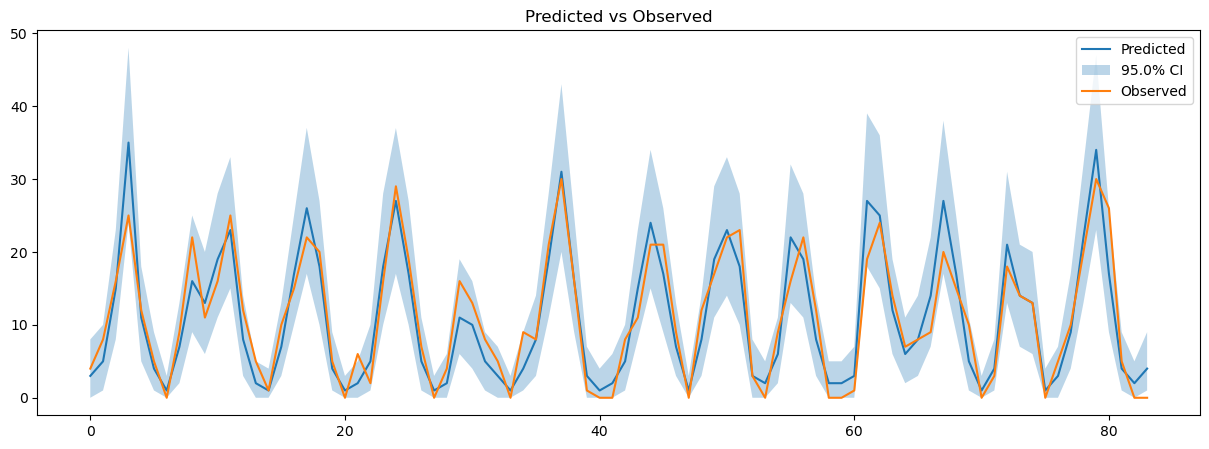

In [80]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

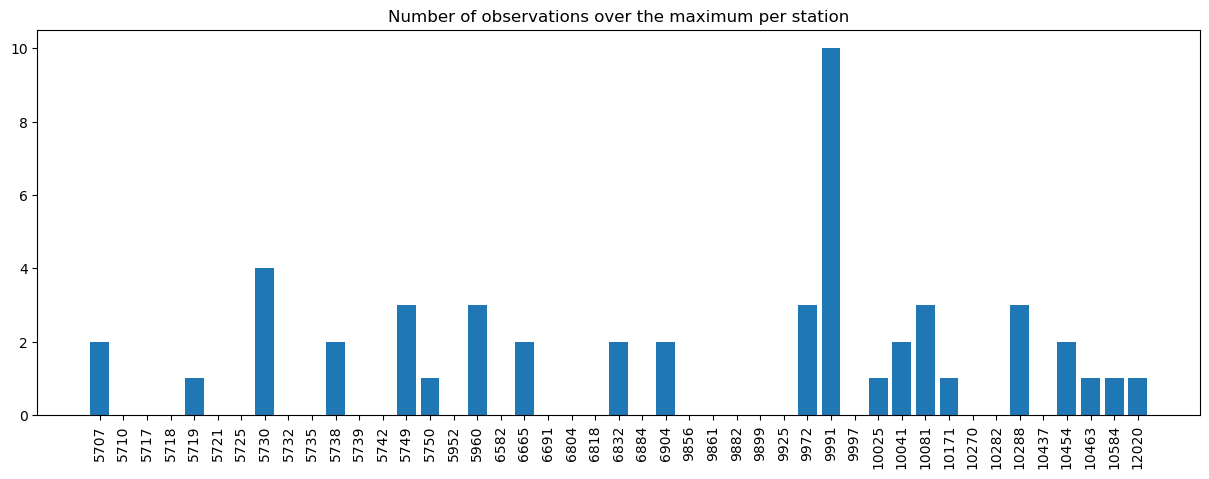

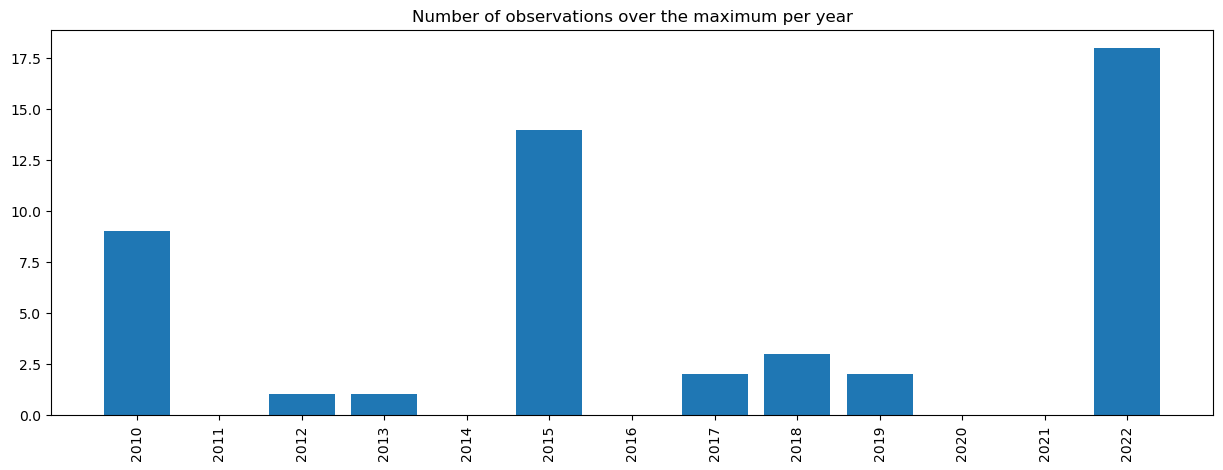

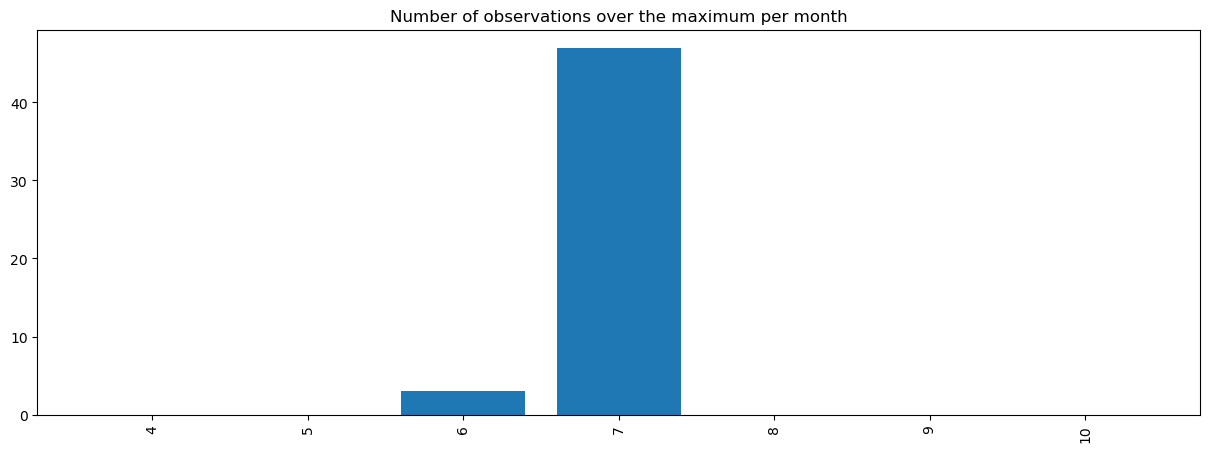

In [81]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [82]:
Model_metrics.loc['Spatial 2',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                   WAIC           LOO        MSE       MAE  MAD inside CI  \
Base      -13592.873226 -13592.929901  29.751562  3.770313  3.0  0.805469   
Years     -11141.536342 -11141.712072  19.525391      3.25  2.0  0.861979   
Stations  -10099.189027 -10099.548656  13.998958  2.791406  2.0  0.910677   
Spatial   -10100.786528 -10101.132555  13.977995  2.791146  2.0  0.911458   
Spatial 2  -10100.15727 -10100.417485  13.974805  2.788411  2.0  0.911458   

          over max  
Base            56  
Years           23  
Stations        48  
Spatial         50  
Spatial 2       50  


# Speace Model with a dummy variable  

In [83]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(Y['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[idx_obs])
dummy_july_miss = pd.Series(dummy_july[idx_miss])


In [84]:
model_space_dummy = FetchModel('space_dummy').compile()

16:56:02 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\space_dummy.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space_dummy.exe
16:57:06 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space_dummy.exe


In [85]:
data_space_july = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs
}

fit_space_july = model_space_dummy.sample(data=data_space_july, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_july = az.from_cmdstanpy(fit_space_july)

16:57:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:01:25 - cmdstanpy - INFO - CmdStan done processing.
17:01:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy.stan', line 42, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy.stan', line 42, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy.stan', line 42, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy.stan', line 42, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy.stan', line 42, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy.stan', line 42, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not 

In [86]:
post_pred = PostPred(posterior_120_july, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

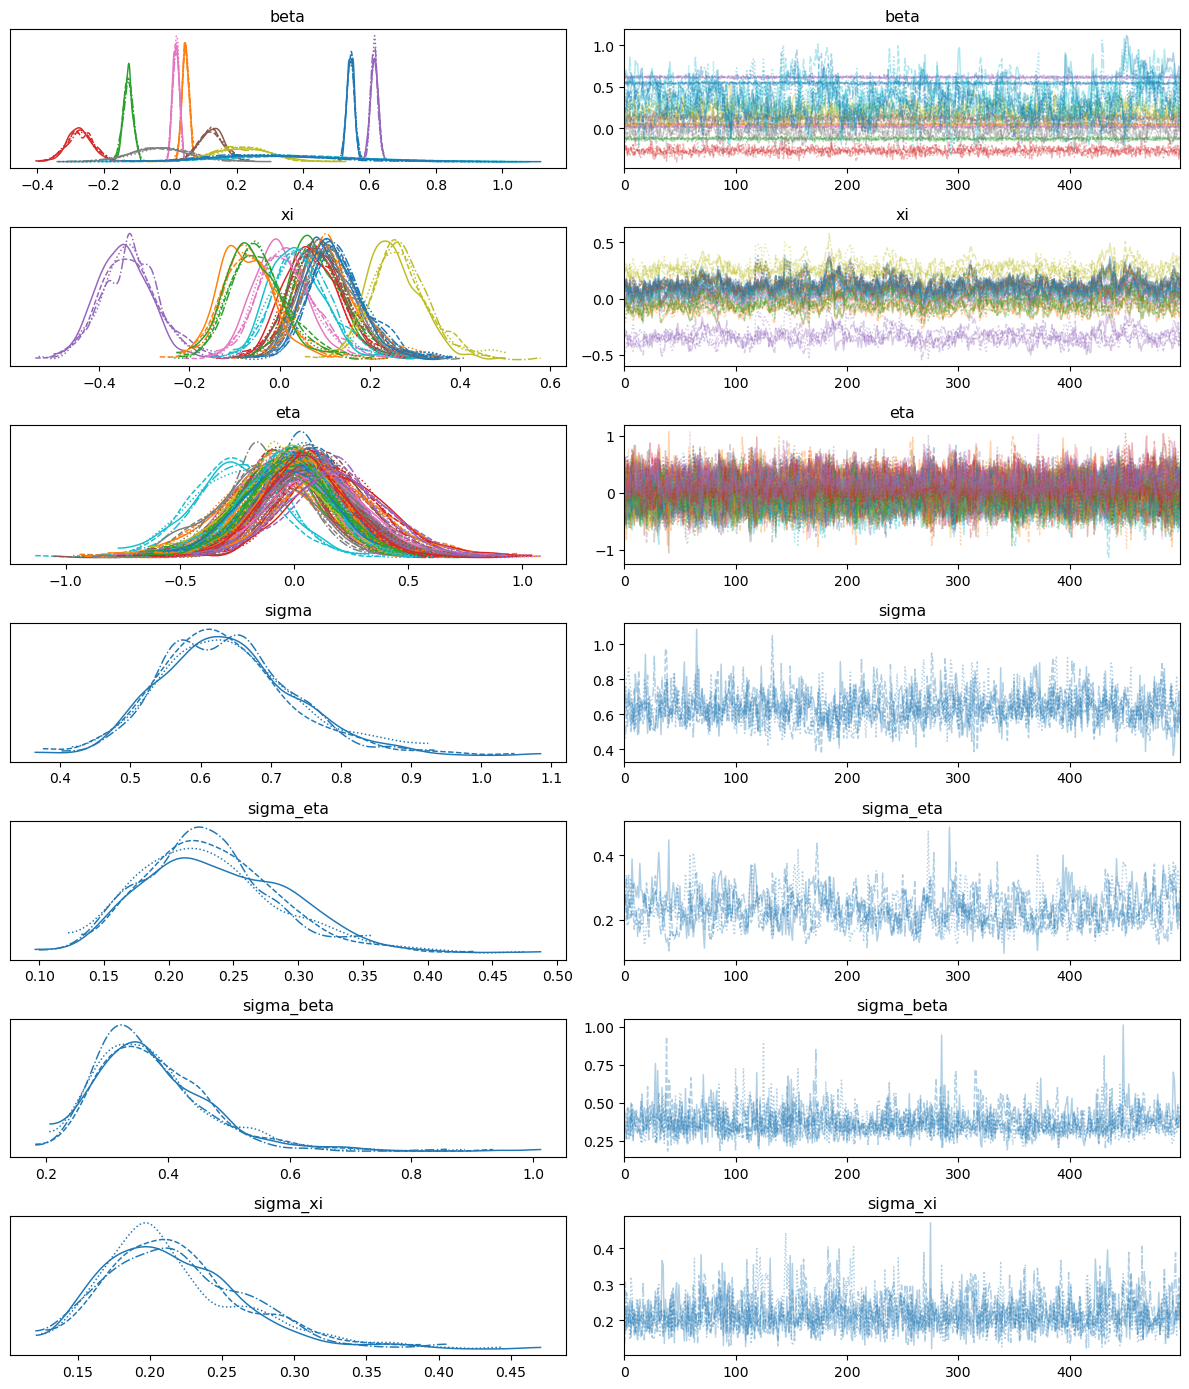

In [87]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [88]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10061.55    86.78
p_waic      158.27        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10062.44    86.80
p_loo      159.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3839  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [89]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [90]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   83  145  154  165  173  227  234  308  309  350  351  362  363
  391  394  396  404  410  414  420  422  429  430  433  472  477  478
  479  481  482  486  488  493  512  513  519  581  582  585  599  609
  618  648  650  662  665  669  680  682  685  690  695  701  718  749
  753  757  769  770  771  774  775  781  787  799  802  807  824  835
  842  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1016 1019 1021 1022 1026 1042 1043 1053 1073
 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1248 1283 1317 1329
 1331 1341 1371 1384 1385 1407 1408 1449 1527 1535 1540 1552 1553 1563
 1611 1631 1667 1774 1786 1824 1859 1867 1869 1874 1880 1889 1897 1903
 1912 1923 1953 1955 1960 1978 1983 1989 2026 2029 2050 2075 2076 2089
 2110 2115 2119 2127 2134 2137 2140 2144 2180 2221 2227 2228 2234 2238
 2251 2274 2291 2301 2315 2327 2332 2363 2367 2375 2382 2398 2399 2406
 2430 2458 2460 2462 2464 2465 2503 2546 2566 2574 2583 2596 2624 2

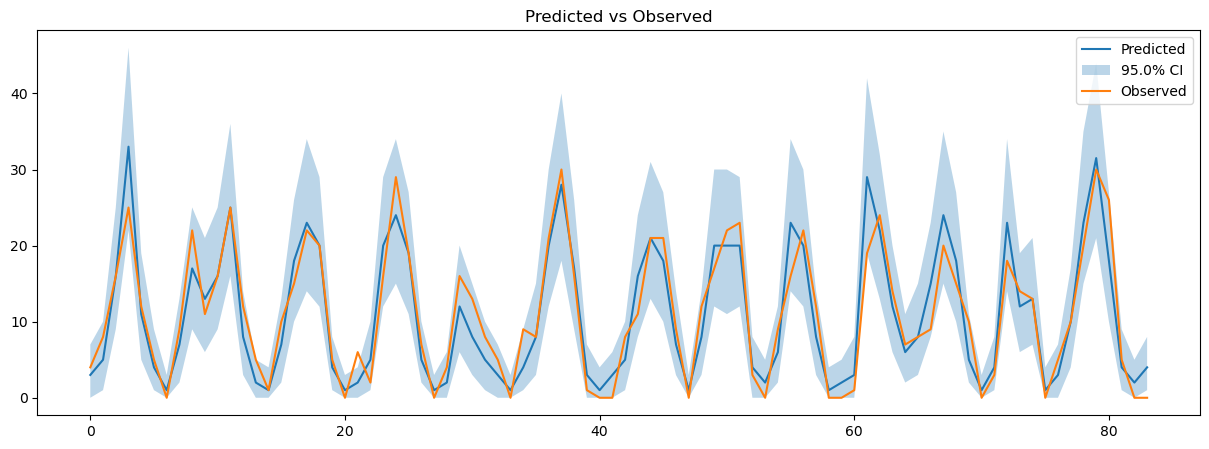

In [91]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [92]:
idx_over_max = np.where(y_obs> max_month_obs)[0]
print(len(idx_over_max))

23


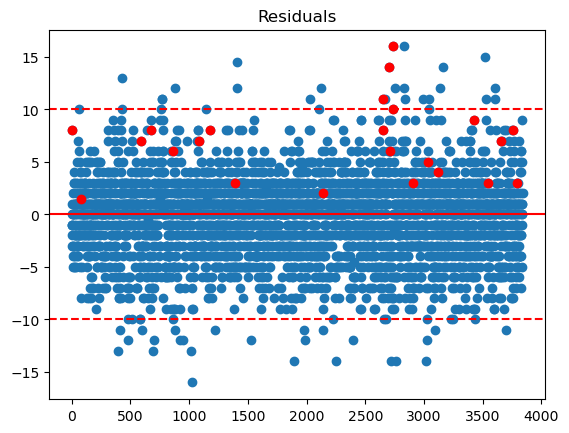

In [93]:
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_max, residuals[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.title('Residuals')
plt.show()

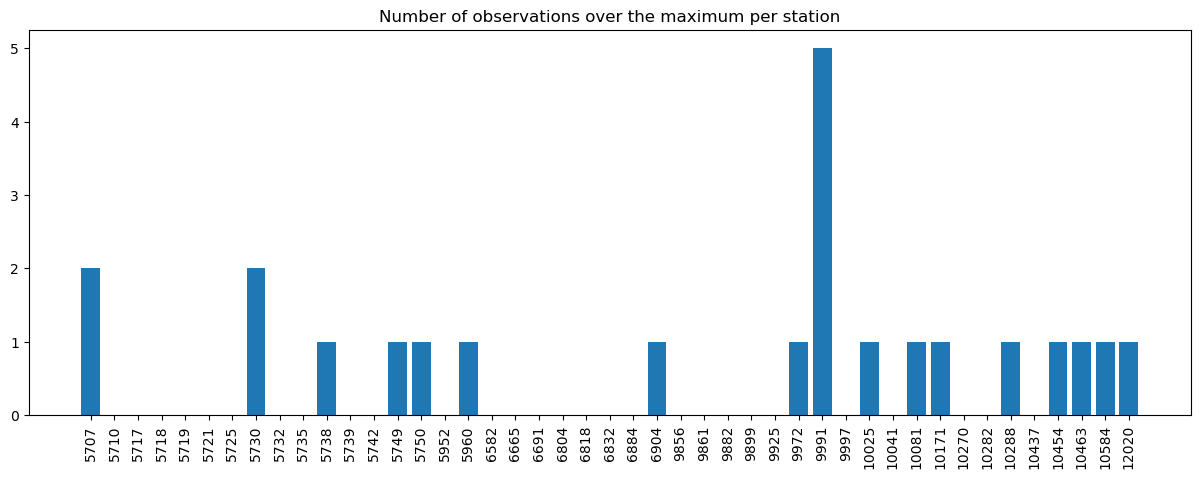

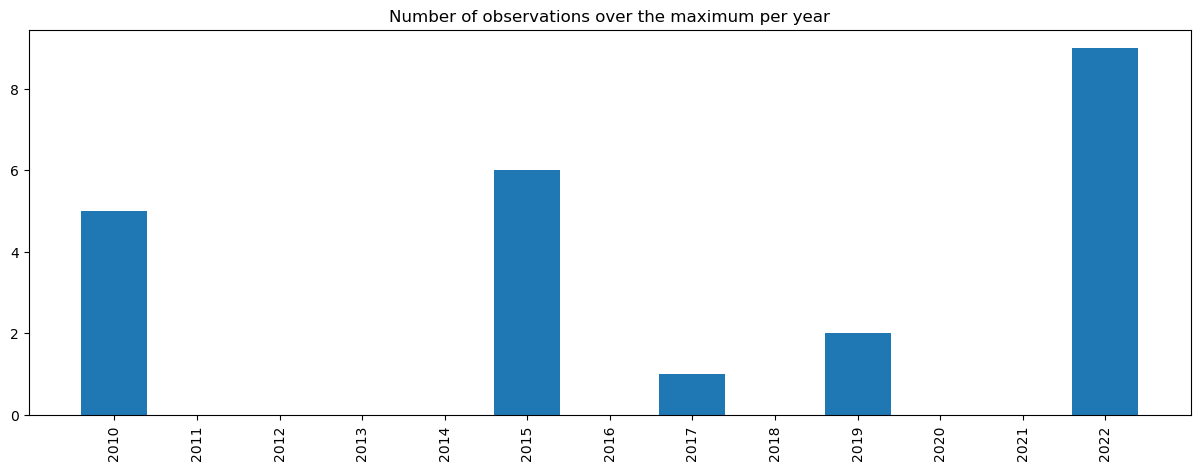

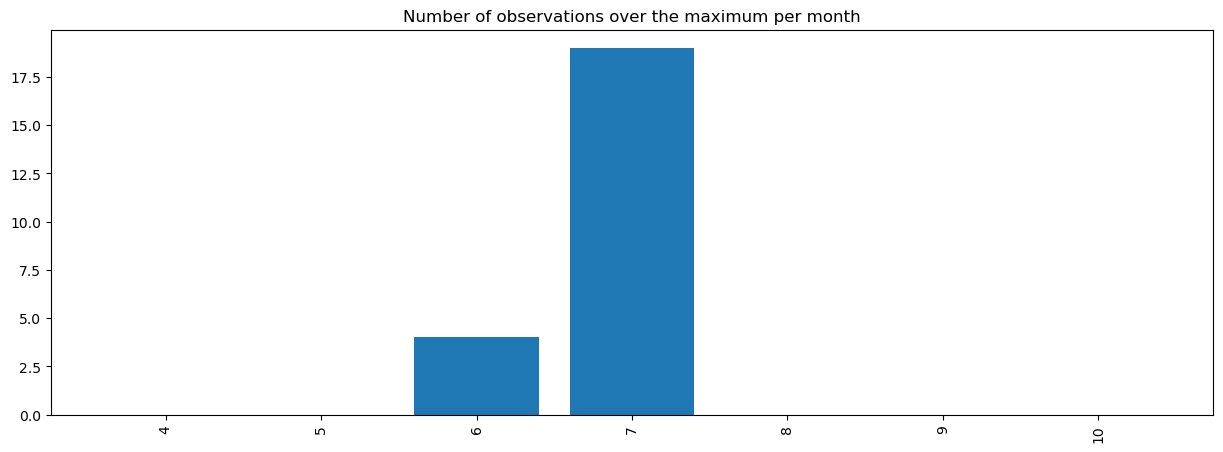

In [94]:
over_max_per_station = pd.Series(np.zeros(len(Y['idSensore'].unique())), index=Y['idSensore'].unique())
over_max_per_year = pd.Series(np.zeros(len(Y['Year'].unique())), index=Y['Year'].unique())
over_max_per_month = pd.Series(np.zeros(len(Y['Month'].unique())), index=Y['Month'].unique())
for i in idx_over_max:
    over_max_per_station[Y_obs['idSensore'][i]] += 1
    over_max_per_year[Y_obs['Year'][i]] += 1
    over_max_per_month[Y_obs['Month'][i]] += 1
over_max_per_station = over_max_per_station.astype(int)
over_max_per_year = over_max_per_year.astype(int)
over_max_per_month = over_max_per_month.astype(int)
over_max_per_station.index = over_max_per_station.index.astype(str)
over_max_per_year.index = over_max_per_year.index.astype(str)
over_max_per_month = over_max_per_month.sort_index()
over_max_per_month.index = over_max_per_month.index.astype(str)


plt.figure(figsize=(15, 5))
plt.bar(over_max_per_station.index, over_max_per_station)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per station')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_year.index, over_max_per_year)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per year')
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(over_max_per_month.index, over_max_per_month)
plt.xticks(rotation=90)
plt.title('Number of observations over the maximum per month')
plt.show()

In [95]:
Model_metrics.loc['Spatial 2 Dummy',:] = [waic, loo, mse, mae, mad, percentage_inside, len(idx_over_max)]
print(Model_metrics)

                         WAIC           LOO        MSE       MAE  MAD  \
Base            -13592.873226 -13592.929901  29.751562  3.770313  3.0   
Years           -11141.536342 -11141.712072  19.525391      3.25  2.0   
Stations        -10099.189027 -10099.548656  13.998958  2.791406  2.0   
Spatial         -10100.786528 -10101.132555  13.977995  2.791146  2.0   
Spatial 2        -10100.15727 -10100.417485  13.974805  2.788411  2.0   
Spatial 2 Dummy -10061.548537 -10062.438864  13.494466  2.734766  2.0   

                inside CI over max  
Base             0.805469       56  
Years            0.861979       23  
Stations         0.910677       48  
Spatial          0.911458       50  
Spatial 2        0.911458       50  
Spatial 2 Dummy  0.917188       23  
